In [24]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

wd = '/home/dwc001/cancer_class'

**Extracellular RNA in a single droplet of human serum reflects physiologic and disease states**

We developed SILVER-seq (Small Input Liquid Volume Extracellular RNA Sequencing) to efficiently sequence both **integral and fragmented cfRNAs** from a small droplet (5-7 microliters) of liquid biopsy. We carried out SILVER-seq on more than **150 serum droplets from male and female donors** ranging from 19 to 48 years of age. SILVER-seq detected cfRNAs from more than a quarter of the human genes, including small RNAs and fragments of mRNAs and long non-coding RNAs (lincRNAs).

128 different samples, consisting of 32 samples from self-reported non-breast-cancer donors, 28 samples from cancer recurrence donors and 68 samples from cancer non-recurrence donors, were constructed to mols-seq libraries for cancer-normal and recurrence-nonrecurrence study.

Get validation dataset from https://github.com/Zhong-Lab-UCSD/breast_cancer_recurrence_classifier

In [2]:
# Load Ensembl ID to gene name mapping
f = open('%s/ensemble_gene_name_map.txt' % wd, 'r')
header = f.readline()

ensemble_id_gene_name_dict = {}

for line in f:
    items = line.strip().split('\t')
    if len(items) > 1:
        ensemble_id_gene_name_dict[items[0]] = items[1]

In [3]:
# Load metadata
metadata = pd.read_csv('%s/pnas_patient_info.csv' % wd)
cancer_idx_recurrence_dict = {} # Maps cancer sample ID to recurrence ('R' or 'N')
recur_count_dict = defaultdict(int)

for sample_id, recur in zip(metadata['sample_id'], metadata['recurStatus']):
    sample_idx = int(sample_id.split('_')[0].split('S')[1])
    cancer_idx_recurrence_dict[sample_idx] = recur
    recur_count_dict[recur] += 1

print(recur_count_dict)

defaultdict(<class 'int'>, {'R': 28, 'N': 68})


In [4]:
# Load cancer data (training set)
cancer_data = pd.read_csv('%s/GSE131512_cancerTPM.txt' % wd, delimiter = '\t')
print(cancer_data.shape)
cancer_data.head()

(60675, 96)


C1         C2         C3         C4         C5  \
ENSG00000000003   7.071605  60.610797  58.255903  29.917356  24.500322   
ENSG00000000005  13.279391  47.424080  60.455497   6.482332  53.675826   
ENSG00000000419   0.000000   0.000000  23.040206   8.646690  20.456404   
ENSG00000000457   6.212355   2.218590  12.120963   6.065120  16.142519   
ENSG00000000460  34.038592  35.828348  55.926653  10.494273  14.482668   

                        C6         C7         C8         C9        C10  ...  \
ENSG00000000003  25.311091  37.394452  15.354658  24.839014  24.591295  ...   
ENSG00000000005  31.686900  32.409716   0.000000  48.976056  46.178684  ...   
ENSG00000000419  42.266702  21.615428  11.538256  18.665274  76.996356  ...   
ENSG00000000457  37.059356   7.580945   0.000000   0.000000  21.603278  ...   
ENSG00000000460  19.236768  13.117055   4.667898  18.877984  12.459809  ...   

                       C87        C88         C89        C90        C91  \
ENSG00000000003  14.134044  10.803910    6.068982  12.714350  15.983392   
ENSG00000000005   0.000000  12.172853  136.759411  28.650721   0.000000   
ENSG00000000419  79.657691   8.118597    0.000000   0.000000   0.000000   
ENSG00000000457  18.624986  15.660412   33.988677   0.000000  36.858404   
ENSG00000000460  17.903438  19.706680   23.062537   1.932615  28.344382   

                        C92        C93        C94         C95        C96  
ENSG00000000003    0.000000  38.189128  15.608352   51.519267  30.805593  
ENSG00000000005    0.000000   5.976111   6.280734  241.863225   0.000000  
ENSG00000000419  179.178412  15.942897   0.000000    0.000000   0.000000  
ENSG00000000457   83.788404  18.172309   2.938248   14.547636  10.148436  
ENSG00000000460    3.020339  27.411791   1.694651    3.729079   7.804221  

[5 rows x 96 columns]

In [5]:
# Load normal data (training set)
normal_data = pd.read_csv('%s/GSE131512_normalTPM.txt' % wd, delimiter = '\t')
print(normal_data.shape)
normal_data.head()

(60675, 32)


N1         N2         N3         N4         N5  \
ENSG00000000003  26.432148  17.260895   0.000000  69.795165  19.331552   
ENSG00000000005  24.817762   5.402219   7.557640   0.000000   0.000000   
ENSG00000000419  66.208114   0.000000  10.081027   0.000000  18.158365   
ENSG00000000457   8.127159   6.318156  15.910242  15.328639  19.105460   
ENSG00000000460   8.035515  20.406574   0.000000  17.681754  11.019179   

                        N6         N7         N8         N9        N10  ...  \
ENSG00000000003   0.000000   2.928341  53.467303  14.997727  25.816814  ...   
ENSG00000000005  14.330953   0.000000  16.733900  14.081717   0.000000  ...   
ENSG00000000419   9.557926   0.000000   0.000000   0.000000   0.000000  ...   
ENSG00000000457   6.704296  34.729107   0.000000   2.195899  20.102628  ...   
ENSG00000000460   1.933370   0.000000  18.060385  10.131976  23.188602  ...   

                       N23        N24        N25        N26        N27  \
ENSG00000000003   2.262858  20.126431   9.225788   4.707643   2.113035   
ENSG00000000005  12.747904  21.259324   0.000000  46.411223   0.000000   
ENSG00000000419   8.502123  18.905005  69.327173   0.000000   7.939198   
ENSG00000000457   5.963715  13.260695  34.040115   7.754309  20.883217   
ENSG00000000460  30.956448   3.824089  16.828134  17.889360  48.178040   

                       N28        N29        N30         N31        N32  
ENSG00000000003  20.452887  16.581454   9.340377    5.074037   4.109799  
ENSG00000000005  64.812467  52.544413   0.000000  100.046777  11.576360  
ENSG00000000419  19.211649  38.937911  35.094127   19.064423  30.883082  
ENSG00000000457   5.053420   6.828136   7.692614    3.343129  13.539111  
ENSG00000000460  13.601410   4.725798  15.972327   19.281682  20.302767  

[5 rows x 32 columns]

In [6]:
# Load validation data (includes cancer and normal)
validation_data = pd.read_csv('%s/validation_exon_tpm.txt' % wd, delimiter = '\t')
print(validation_data.shape)
validation_samples = validation_data.columns

(60675, 161)


In [7]:
# Load validation metadata
bc_metadata = pd.read_csv('%s/validation_bc_meta.csv' % wd)
normal_metadata = pd.read_csv('%s/validation_normal_meta.csv' % wd)
metadata

val_sample_cancer_dict = {} # Maps sample ID to cancer status ('C' or 'N')
val_sample_recurrence_dict = {} # Maps cancer sample ID (in validation set) to recurrence ('R' or 'N')
val_cancer_count_dict = defaultdict(int)
val_recur_count_dict = defaultdict(int)

for sample_id, recur in zip(bc_metadata['Mapping ID'], bc_metadata['Recurrence Staus at the time of collection']):
    val_sample_recurrence_dict[sample_id] = recur
    val_sample_cancer_dict[sample_id] = 'C'
    val_recur_count_dict[recur] += 1
    val_cancer_count_dict['C'] += 1

for sample_id in normal_metadata['Mapping ID']:
    val_sample_cancer_dict[sample_id] = 'N'
    val_cancer_count_dict['N'] += 1

In [8]:
# Split validation data into cancer and normal dataframes for convenience

val_cancer_samples_dict = defaultdict(list)
for sample in val_sample_cancer_dict:
    cancer_status = val_sample_cancer_dict[sample]
    val_cancer_samples_dict[cancer_status].append(sample)

val_cancer_data = validation_data[val_cancer_samples_dict['C']]
val_normal_data = validation_data[val_cancer_samples_dict['N']]

In [9]:
# Overview of number of validation samples
print("Total number of samples: %i" % len(validation_samples))
print(val_cancer_count_dict)
print(val_recur_count_dict)

Total number of samples: 161
defaultdict(<class 'int'>, {'C': 83, 'N': 78})
defaultdict(<class 'int'>, {'Nonrecurrent': 75, 'Recurrent': 8})


# PCA on cancer vs. normal

In [10]:
# Function to get feature table matrix (X) and labels (y)
def get_cancer_status_data():
    y = []; X = []
    for col_id in cancer_data.columns:
        y.append(1); X.append(np.array(cancer_data[col_id]))
    
    for col_id in normal_data.columns:
        y.append(0); X.append(np.array(normal_data[col_id]))
    
    y = np.array(y); X = np.array(X)
    return X, y

Text(0.5, 1.0, 'Training only (n=128)')

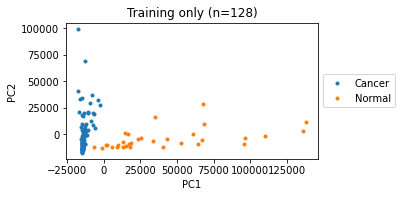

In [11]:
# See how samples separate using PCA
from sklearn.decomposition import PCA

labels = []; X = []
for col_id in cancer_data.columns:
    labels.append('Cancer'); X.append(np.array(cancer_data[col_id]))

for col_id in normal_data.columns:
    labels.append('Normal'); X.append(np.array(normal_data[col_id]))

# PCA and PLOT
pca = PCA(n_components=2); pcs = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(4.5, 2.5))

label_pc1s_dict = defaultdict(list); label_pc2s_dict = defaultdict(list)
for pc_tup, label in zip(pcs, labels):
    pc1, pc2 = pc_tup
    label_pc1s_dict[label].append(pc1); label_pc2s_dict[label].append(pc2)

for label in label_pc1s_dict:
    ax.plot(label_pc1s_dict[label], label_pc2s_dict[label], '.', label=label)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title('Training only (n=%i)' % len(X))

Text(0.5, 1.0, 'Training only (n=128), log-transformed TPM')

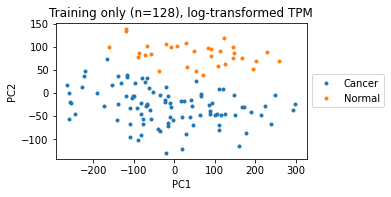

In [12]:
# Try with log transformed values
X_log = np.log2(np.array(X)+1)

pca = PCA(n_components=2); pcs = pca.fit_transform(X_log)

fig, ax = plt.subplots(figsize=(4.5, 2.5))

label_pc1s_dict = defaultdict(list); label_pc2s_dict = defaultdict(list)
for pc_tup, label in zip(pcs, labels):
    pc1, pc2 = pc_tup
    label_pc1s_dict[label].append(pc1); label_pc2s_dict[label].append(pc2)

for label in label_pc1s_dict:
    ax.plot(label_pc1s_dict[label], label_pc2s_dict[label], '.', label=label)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title('Training only (n=%i), log-transformed TPM' % len(X))

In [13]:
# Throw in validation data for good measure
# Function to get feature table matrix (X) and labels (y)
def get_cancer_status_data_with_val():
    y = []; X = []
    val_y = []; val_X = []
    
    for col_id in cancer_data.columns:
        y.append(1); X.append(np.array(cancer_data[col_id]))
    
    for col_id in validation_data.columns:
        cancer_status = val_sample_cancer_dict[col_id]
        if cancer_status == 'C':
            val_y.append(1); val_X.append(np.array(validation_data[col_id]))
        elif cancer_status == 'N':
            val_y.append(0); val_X.append(np.array(validation_data[col_id]))

    for col_id in normal_data.columns:
        y.append(0); X.append(np.array(normal_data[col_id]))

    y = np.array(y); X = np.array(X)
    val_y = np.array(val_y); val_X = np.array(val_X)
    return X, y, val_X, val_y

Text(0.5, 1.0, 'Combined (n=289)')

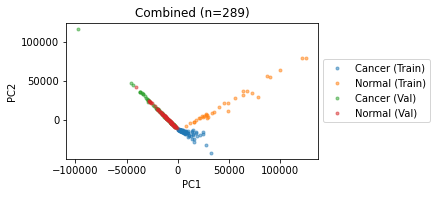

In [14]:
# See how samples separate using PCA

labels = []; X = []
for col_id in cancer_data.columns:
    labels.append('Cancer (Train)'); X.append(np.array(cancer_data[col_id]))

for col_id in validation_data.columns:
    cancer_status = val_sample_cancer_dict[col_id]
    if cancer_status == 'C':
        labels.append('Cancer (Val)'); X.append(np.array(validation_data[col_id]))
    elif cancer_status == 'N':
        labels.append('Normal (Val)'); X.append(np.array(validation_data[col_id]))

for col_id in normal_data.columns:
    labels.append('Normal (Train)'); X.append(np.array(normal_data[col_id]))

pca = PCA(n_components=2)
pcs = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(4.5, 2.5))

label_pc1s_dict = defaultdict(list); label_pc2s_dict = defaultdict(list)
for pc_tup, label in zip(pcs, labels):
    pc1, pc2 = pc_tup
    label_pc1s_dict[label].append(pc1); label_pc2s_dict[label].append(pc2)

for label in ['Cancer (Train)', 'Normal (Train)', 'Cancer (Val)', 'Normal (Val)']:
    ax.plot(label_pc1s_dict[label], label_pc2s_dict[label], '.', label=label, alpha=0.5)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title('Combined (n=%i)' % len(X))

Text(0.5, 1.0, 'Combined (n=289), log-transformed TPM')

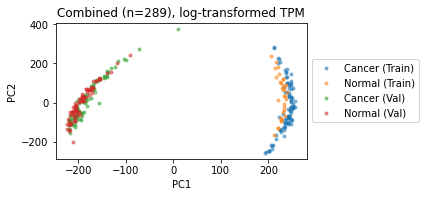

In [15]:
# Try with log transformed values
X_log = np.log2(np.array(X)+1)

pca = PCA(n_components=2); pcs = pca.fit_transform(X_log)

fig, ax = plt.subplots(figsize=(4.5, 2.5))

label_pc1s_dict = defaultdict(list); label_pc2s_dict = defaultdict(list)
for pc_tup, label in zip(pcs, labels):
    pc1, pc2 = pc_tup
    label_pc1s_dict[label].append(pc1); label_pc2s_dict[label].append(pc2)

for label in ['Cancer (Train)', 'Normal (Train)', 'Cancer (Val)', 'Normal (Val)']:
    ax.plot(label_pc1s_dict[label], label_pc2s_dict[label], '.', label=label, alpha=0.5)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.set_title('Combined (n=%i), log-transformed TPM' % len(X))

# PCA on reccurrence vs. non-reccurrence

In [16]:
# Now split into recurrence vs. non-recurrence
# Throw in validation data for good measure
# Function to get feature table matrix (X) and labels (y)
def get_recur_status_data_with_val():
    y = []; X = []
    val_y = []; val_X = []
    
    for col_i in range(len(cancer_data.columns)): # almost equivalent to sample idx
        recur = cancer_idx_recurrence_dict[col_i+1]
        y.append(1 if recur == 'R' else 0); X.append(np.array(cancer_data.iloc[:, col_i]))
    
    for col_id in validation_data.columns:
        if col_id in val_sample_recurrence_dict: # Cancer sample, not normal
            recur_status = val_sample_recurrence_dict[col_id]
            if recur_status == 'Recurrent':
                val_y.append(1); val_X.append(np.array(validation_data[col_id]))
            elif recur_status == 'Nonrecurrent':
                val_y.append(0); val_X.append(np.array(validation_data[col_id]))
    
    y = np.array(y); X = np.array(X)
    val_y = np.array(val_y); val_X = np.array(val_X)
    return X, y, val_X, val_y

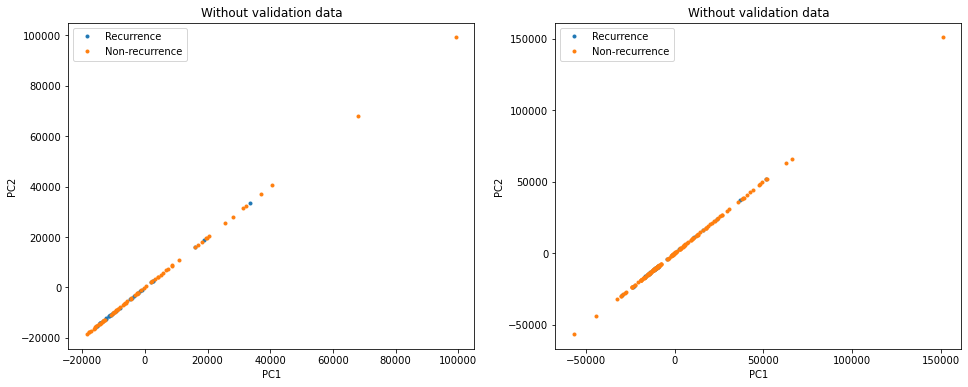

In [17]:
# See how samples separate using PCA
from sklearn.decomposition import PCA

X, y, val_X, val_y = get_recur_status_data_with_val()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for i in [0,1]:
    plot_X = X if i == 0 else np.concatenate((X, val_X))
    plot_y = y if i == 0 else np.concatenate((y, val_y))
    
    pca = PCA(n_components=2); pcs = pca.fit_transform(plot_X)
    
    # Recurrence vs. non-recurrence
    recur_pc1s_dict = defaultdict(list); recur_pc2s_dict = defaultdict(list)
    for recur, pc_tup in zip(plot_y, pcs):
        pc1, pc2 = pc_tup
        recur_pc1s_dict[recur].append(pc1); recur_pc2s_dict[recur].append(pc2)
    
    for recur in recur_pc1s_dict:
        label = 'Recurrence' if recur == 1 else 'Non-recurrence'
        ax[i].plot(recur_pc1s_dict[recur], recur_pc1s_dict[recur], '.', label=label)

    ax[i].legend(); ax[i].set_xlabel("PC1"); ax[i].set_ylabel("PC2"); ax[i].set_title("Without validation data")

# The problem

Want to use machine learning to produce a binary classifier. In this case, we have limited training data available, a very large number of potential features (expression of ~60,000 genes) and an approximately 25-75 split between the two classes, breast cancer (96 samples) vs. non-cancer (32 samples). The validation dataset consists of 83 cancer, 78 non-cancer samples.

In [17]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# X: Rows are samples, columns are features
# y: Sample labels (1 for cancer, 0 for non-cancer)
X, y, X_val, y_val = get_cancer_status_data_with_val()

# Simple first pass: use all training data and "test" using validation set
mnb = MultinomialNB().fit(X, y)
print("Training set score: "+ str(mnb.score(X, y)))
print("Validation set score: "+ str(mnb.score(X_val, y_val)))

# Second: split training set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

mnb = MultinomialNB().fit(X_train, y_train)
print("Training set score: "+ str(mnb.score(X_train, y_train)))
print("Validation set score: "+ str(mnb.score(X_val, y_val)))
print("Test set score: "+ str(mnb.score(X_test, y_test)))

Training set score: 1.0
Validation set score: 0.515527950310559
Training set score: 1.0
Validation set score: 0.515527950310559
Test set score: 0.9615384615384616


In [18]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

X, y, X_val, y_val = get_cancer_status_data_with_val()

# Simple first pass: use all training data and "test" using validation set
lr = LogisticRegression(max_iter=1000); lr.fit(X, y)
print("Training set score: "+ str(lr.score(X, y)))
print("Validation set score: "+ str(lr.score(X_val, y_val)))

# Second: split training set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
lr = LogisticRegression(max_iter=1000); lr.fit(X_train, y_train)
print("Training set score: "+ str(lr.score(X_train, y_train)))
print("Validation set score: "+ str(lr.score(X_val, y_val)))
print("Test set score: "+ str(lr.score(X_test, y_test)))

Training set score: 1.0
Validation set score: 0.515527950310559
Training set score: 1.0
Validation set score: 0.515527950310559
Test set score: 1.0


In [19]:
# SVM
from sklearn.svm import LinearSVC

X, y, X_val, y_val = get_cancer_status_data_with_val()

# Simple first pass: use all training data and "test" using validation set
svm = LinearSVC(C=0.0001); svm.fit(X, y)
print("Training set score: "+ str(svm.score(X, y)))
print("Validation set score: "+ str(svm.score(X_val, y_val)))

# Second: split training set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
svm = LinearSVC(C=0.0001); svm.fit(X_train, y_train)
print("Training set score: "+ str(svm.score(X_train, y_train)))
print("Validation set score: "+ str(svm.score(X_val, y_val)))
print("Test set score: "+ str(svm.score(X_test, y_test)))

Training set score: 1.0
Validation set score: 0.515527950310559
Training set score: 1.0
Validation set score: 0.515527950310559
Test set score: 1.0


In [20]:
# Third: combine training and validation, then do train-test split
X_comb = np.concatenate((X, X_val)); y_comb = np.concatenate((y, y_val))
X_train, X_test, y_train, y_test = train_test_split(X_comb, y_comb, test_size=0.4)
svm = LinearSVC(C=0.0001); svm.fit(X_train, y_train)
print("Training set score: "+ str(svm.score(X_train, y_train)))
print("Test set score: "+ str(svm.score(X_test, y_test)))

Training set score: 1.0
Test set score: 0.8706896551724138


In [32]:
# Test different regularization parameters C
Cs = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2]
training_scores = []; val_scores = []
for C in Cs:
    svm = LinearSVC(C=C); svm.fit(X_train, y_train)
    training_scores.append(svm.score(X_train, y_train))
    val_scores.append(svm.score(X_test, y_test))

In [33]:
val_scores # Has no effect for this tiny dataset, I suppose...

[0.853448275862069,
 0.853448275862069,
 0.853448275862069,
 0.853448275862069,
 0.853448275862069,
 0.853448275862069,
 0.853448275862069,
 0.853448275862069]

# Feature engineering attempts for cancer vs. non-cancer

In [18]:
# Idea 1: order genes/features by p-value of t-test between two classes
# Firstly just look within the training set

gene_pval_dict = {}

genes = list(cancer_data.index)

for gene in tqdm(genes):
    cancer_exprs = np.array(cancer_data.loc[gene])
    normal_exprs = np.array(normal_data.loc[gene])
    t, p = stats.ttest_ind(cancer_exprs, normal_exprs)
    gene_pval_dict[gene] = p

100%|███████████████████████████████████| 60675/60675 [00:14<00:00, 4130.82it/s]


In [19]:
sorted_gene_pval_tups = sorted(gene_pval_dict.items(), key=lambda x: x[1])[:10]

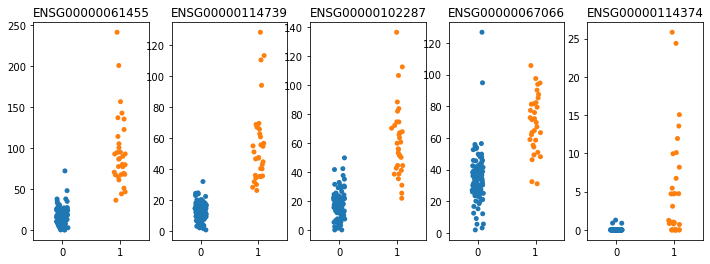

In [20]:
# Violinplots for these genes

k=5

fig, ax = plt.subplots(1, k, figsize=(12, 4))

i = 0
for gene, pval in sorted_gene_pval_tups[:k]:
    cancer_exprs = np.array(cancer_data.loc[gene])
    normal_exprs = np.array(normal_data.loc[gene])
    sns.stripplot(data=[cancer_exprs, normal_exprs], ax=ax[i])
    ax[i].set_title(gene)
    i += 1

In [21]:
# Try instead with log normalized

gene_pval_dict = {}

genes = list(cancer_data.index)

for gene in tqdm(genes):
    cancer_exprs = np.log2(np.array(cancer_data.loc[gene])+1)
    normal_exprs = np.log2(np.array(normal_data.loc[gene])+1)
    t, p = stats.ttest_ind(cancer_exprs, normal_exprs)
    gene_pval_dict[gene] = p

100%|███████████████████████████████████| 60675/60675 [00:14<00:00, 4105.65it/s]


In [22]:
sorted_gene_pval_tups = sorted(gene_pval_dict.items(), key=lambda x: x[1])[:10]

sorted_genes = [] # genes sorted by p-value for cancer status t-test

for gene, pval in sorted(gene_pval_dict.items(), key=lambda x: x[1]):
    sorted_genes.append(gene)

<AxesSubplot:>

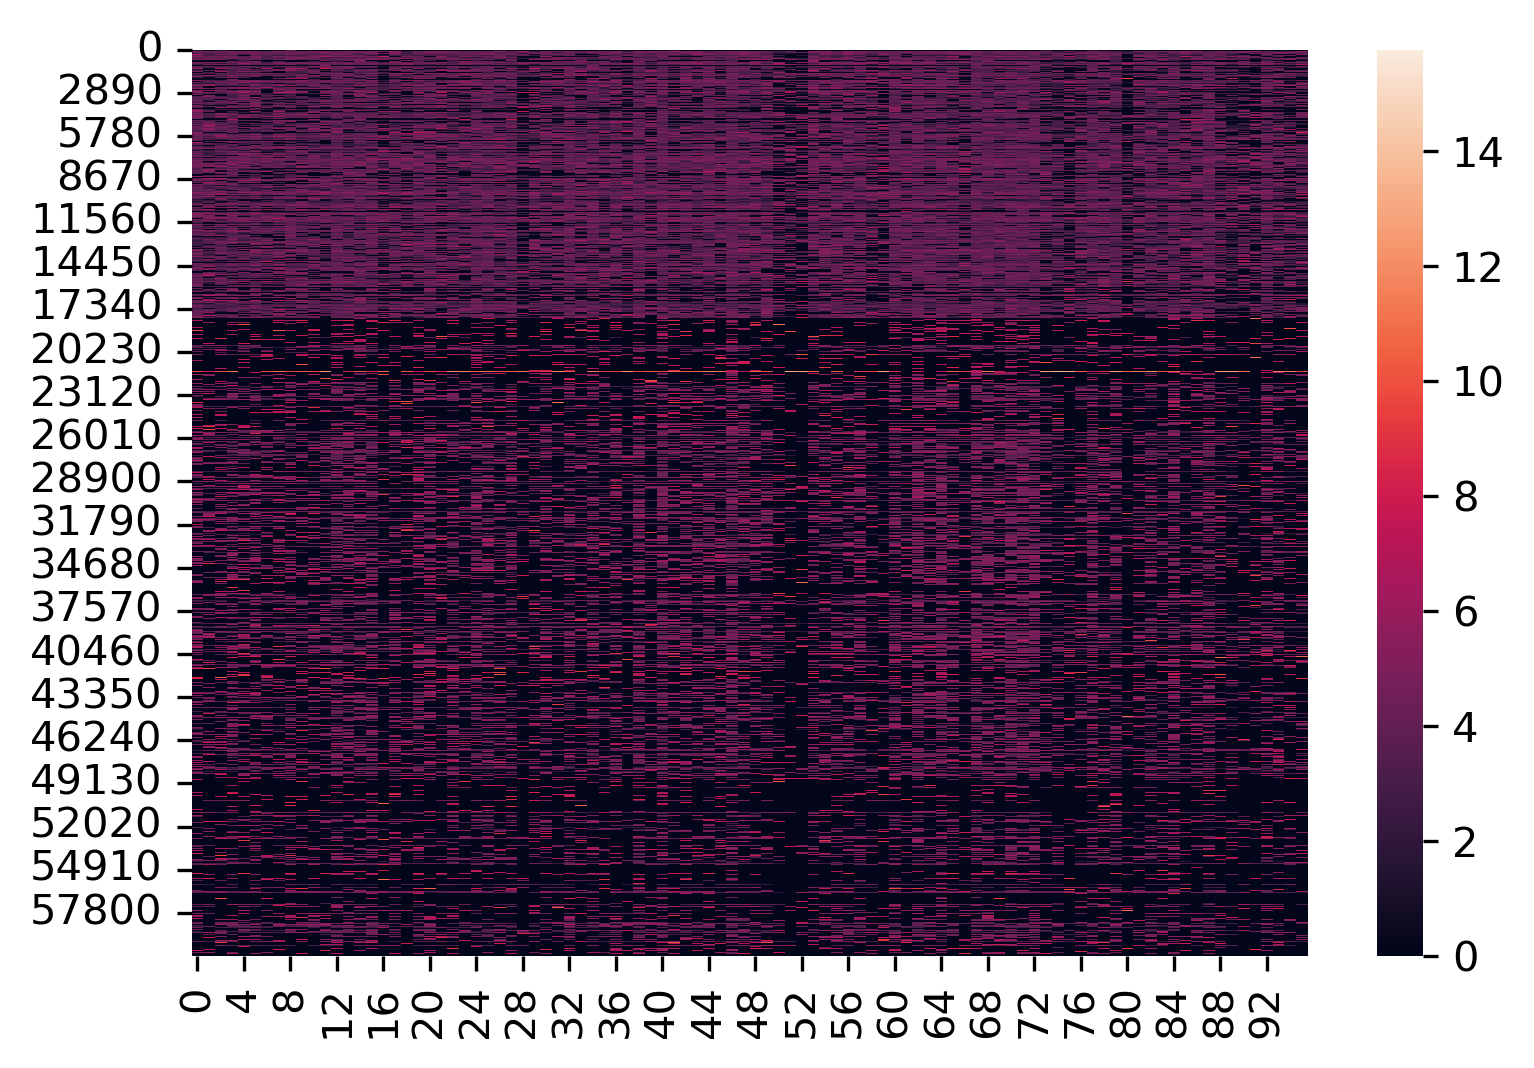

In [25]:
# Visualize cancer TPM values (log transformed)
# Order genes by difference between cancer and normal
cancer_data_matrix = np.array(cancer_data)

reordered_cancer_data_matrix = []
for gene in sorted_genes:
    reordered_cancer_data_matrix.append(np.array(cancer_data.loc[gene]))

reordered_cancer_data_matrix = np.array(reordered_cancer_data_matrix)
sns.heatmap(np.log2(reordered_cancer_data_matrix+1))

In [26]:
# Try clustering by sample
import scipy.cluster.hierarchy

Z = scipy.cluster.hierarchy.linkage(reordered_cancer_data_matrix.T)
ordered_samples_idxs = scipy.cluster.hierarchy.leaves_list(Z)

<AxesSubplot:>

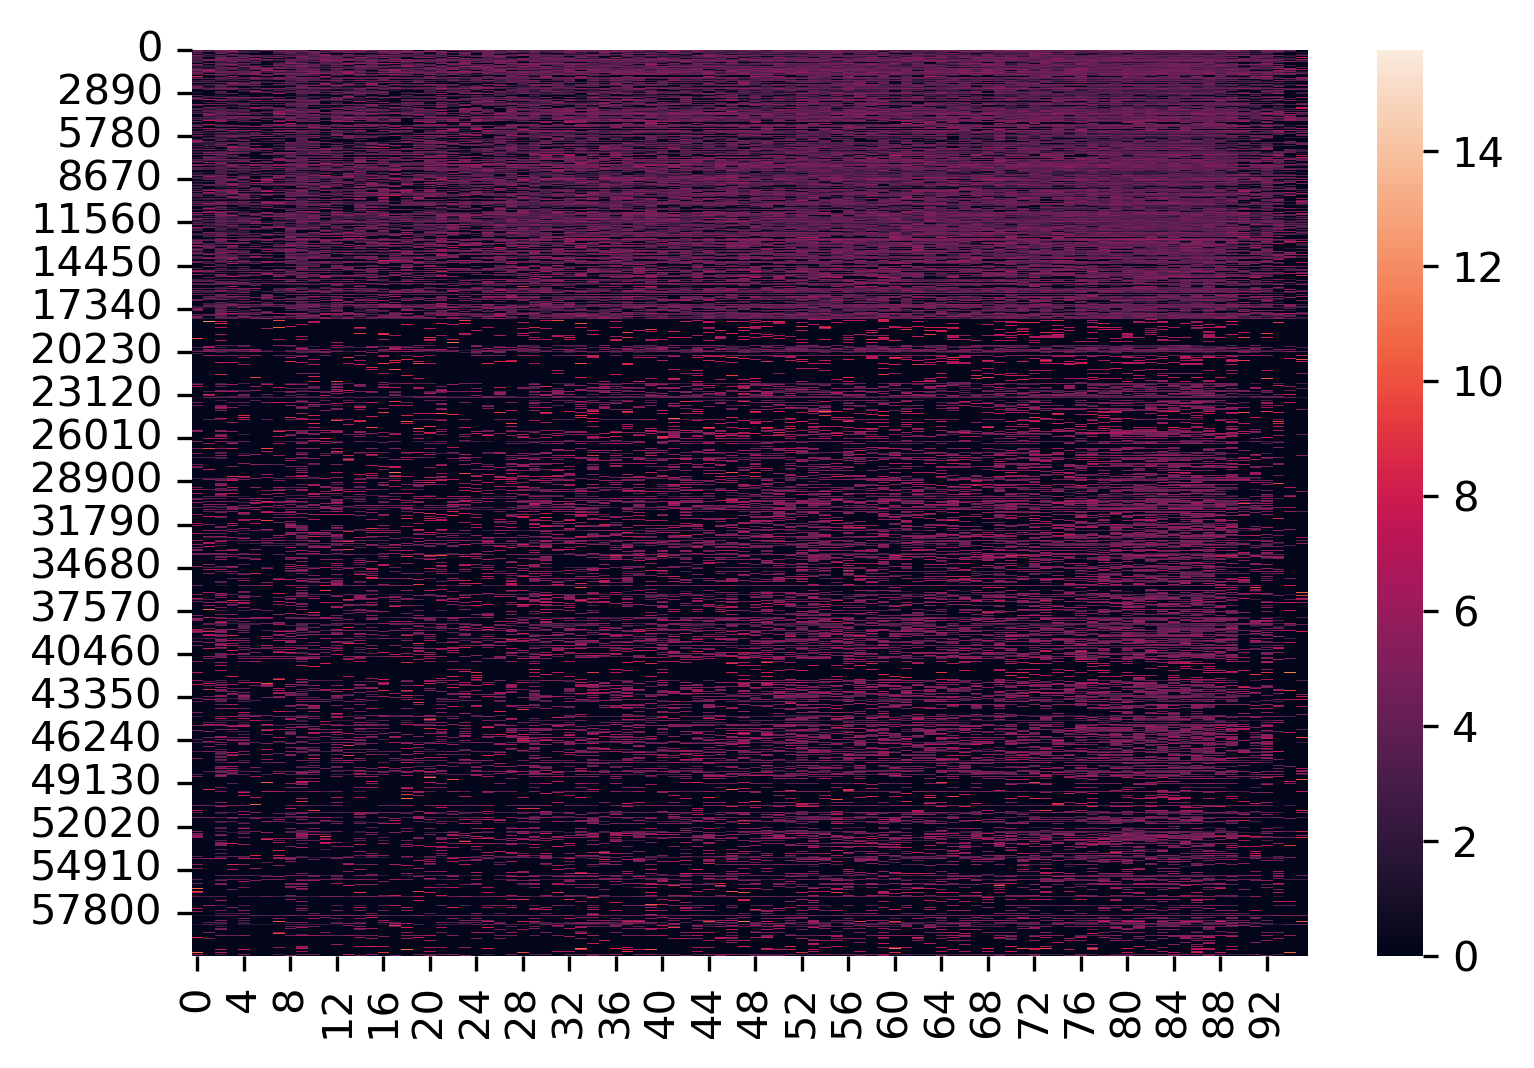

In [27]:
reordered_cancer_data_matrix_2 = []
for sample_idx in ordered_samples_idxs:
    reordered_cancer_data_matrix_2.append(np.array(cancer_data.iloc[:,sample_idx]))

reordered_cancer_data_matrix_2 = np.array(reordered_cancer_data_matrix_2).T

sns.heatmap(np.log2(reordered_cancer_data_matrix_2+1))

<AxesSubplot:>

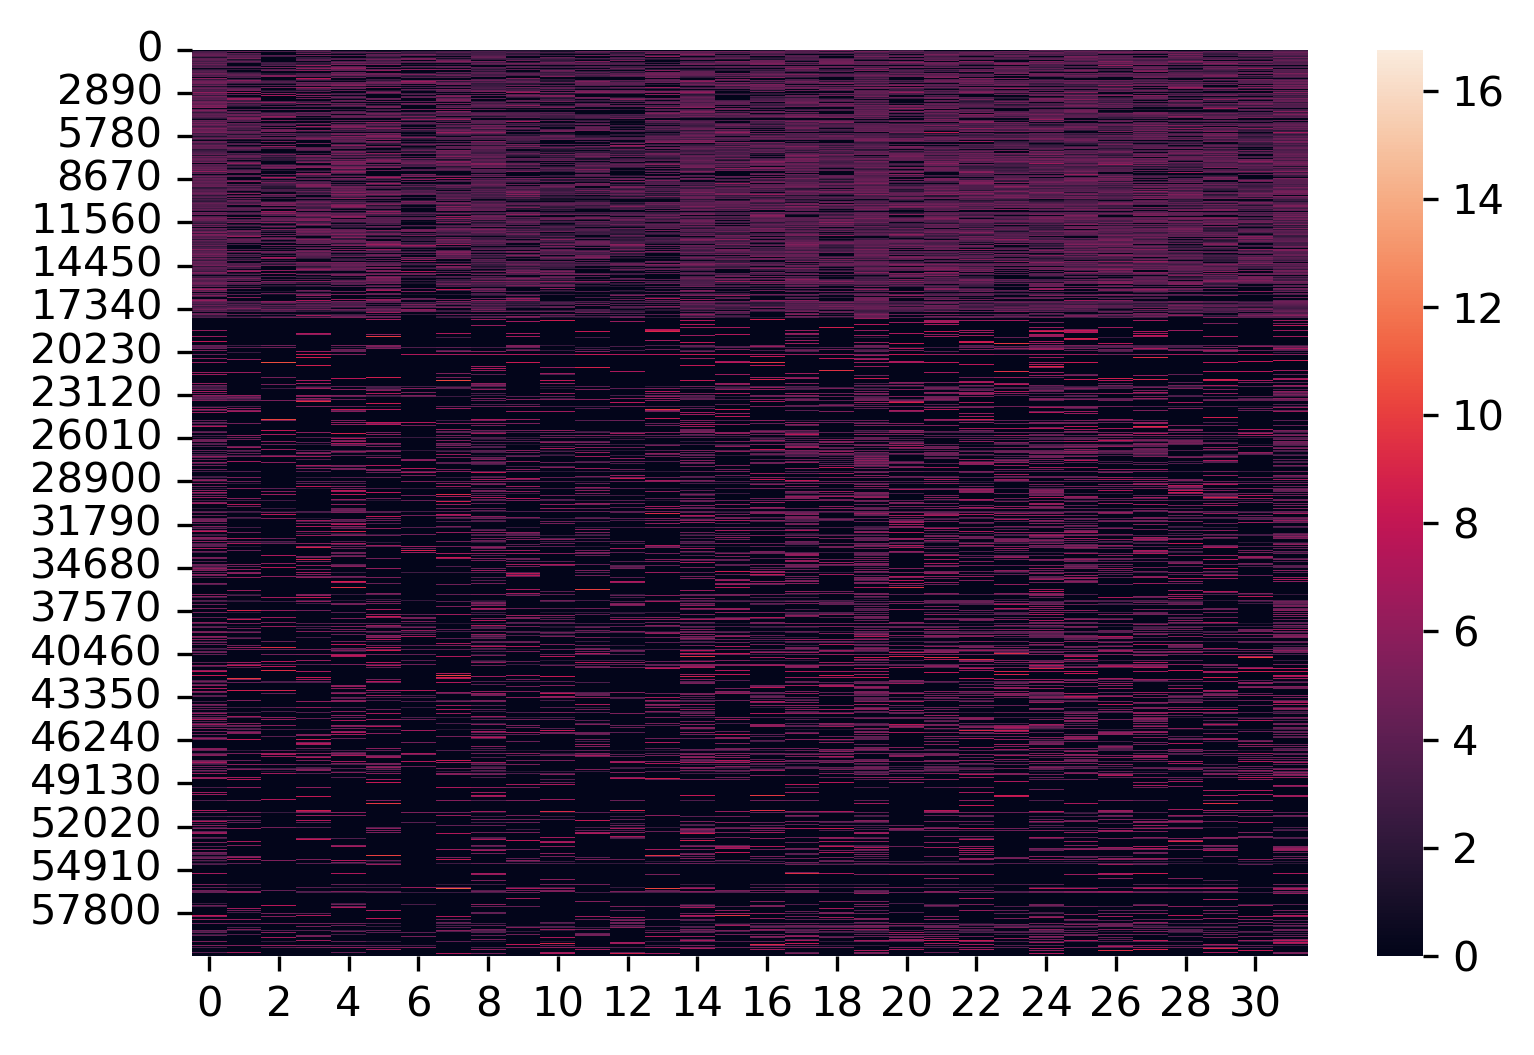

In [28]:
# Visualize normal TPM values (log transformed)
# Order genes by difference between normal and normal
normal_data_matrix = np.array(normal_data)

reordered_normal_data_matrix = []
for gene in sorted_genes:
    reordered_normal_data_matrix.append(np.array(normal_data.loc[gene]))

reordered_normal_data_matrix = np.array(reordered_normal_data_matrix)
sns.heatmap(np.log2(reordered_normal_data_matrix+1))

In [29]:
# Try clustering by sample
import scipy.cluster.hierarchy

Z = scipy.cluster.hierarchy.linkage(reordered_normal_data_matrix.T)
ordered_samples_idxs = scipy.cluster.hierarchy.leaves_list(Z)

<AxesSubplot:>

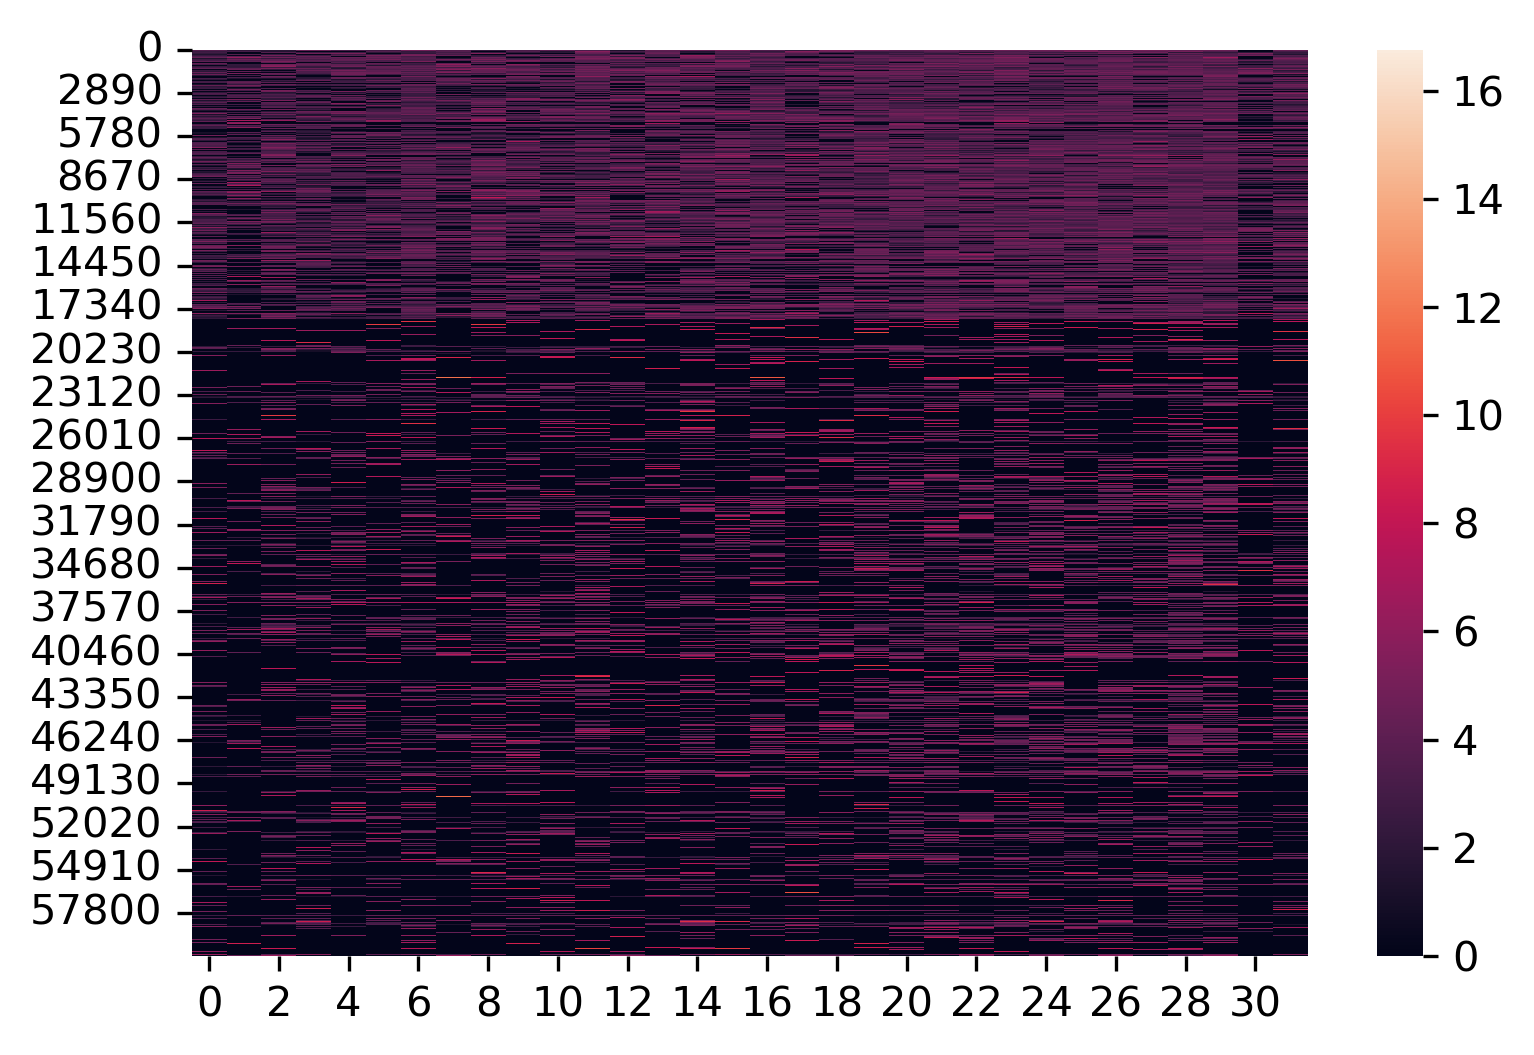

In [30]:
reordered_normal_data_matrix_2 = []
for sample_idx in ordered_samples_idxs:
    reordered_normal_data_matrix_2.append(np.array(normal_data.iloc[:,sample_idx]))

reordered_normal_data_matrix_2 = np.array(reordered_normal_data_matrix_2).T

sns.heatmap(np.log2(reordered_normal_data_matrix_2+1))

Text(514.1666666666667, 0.5, 'Gene')

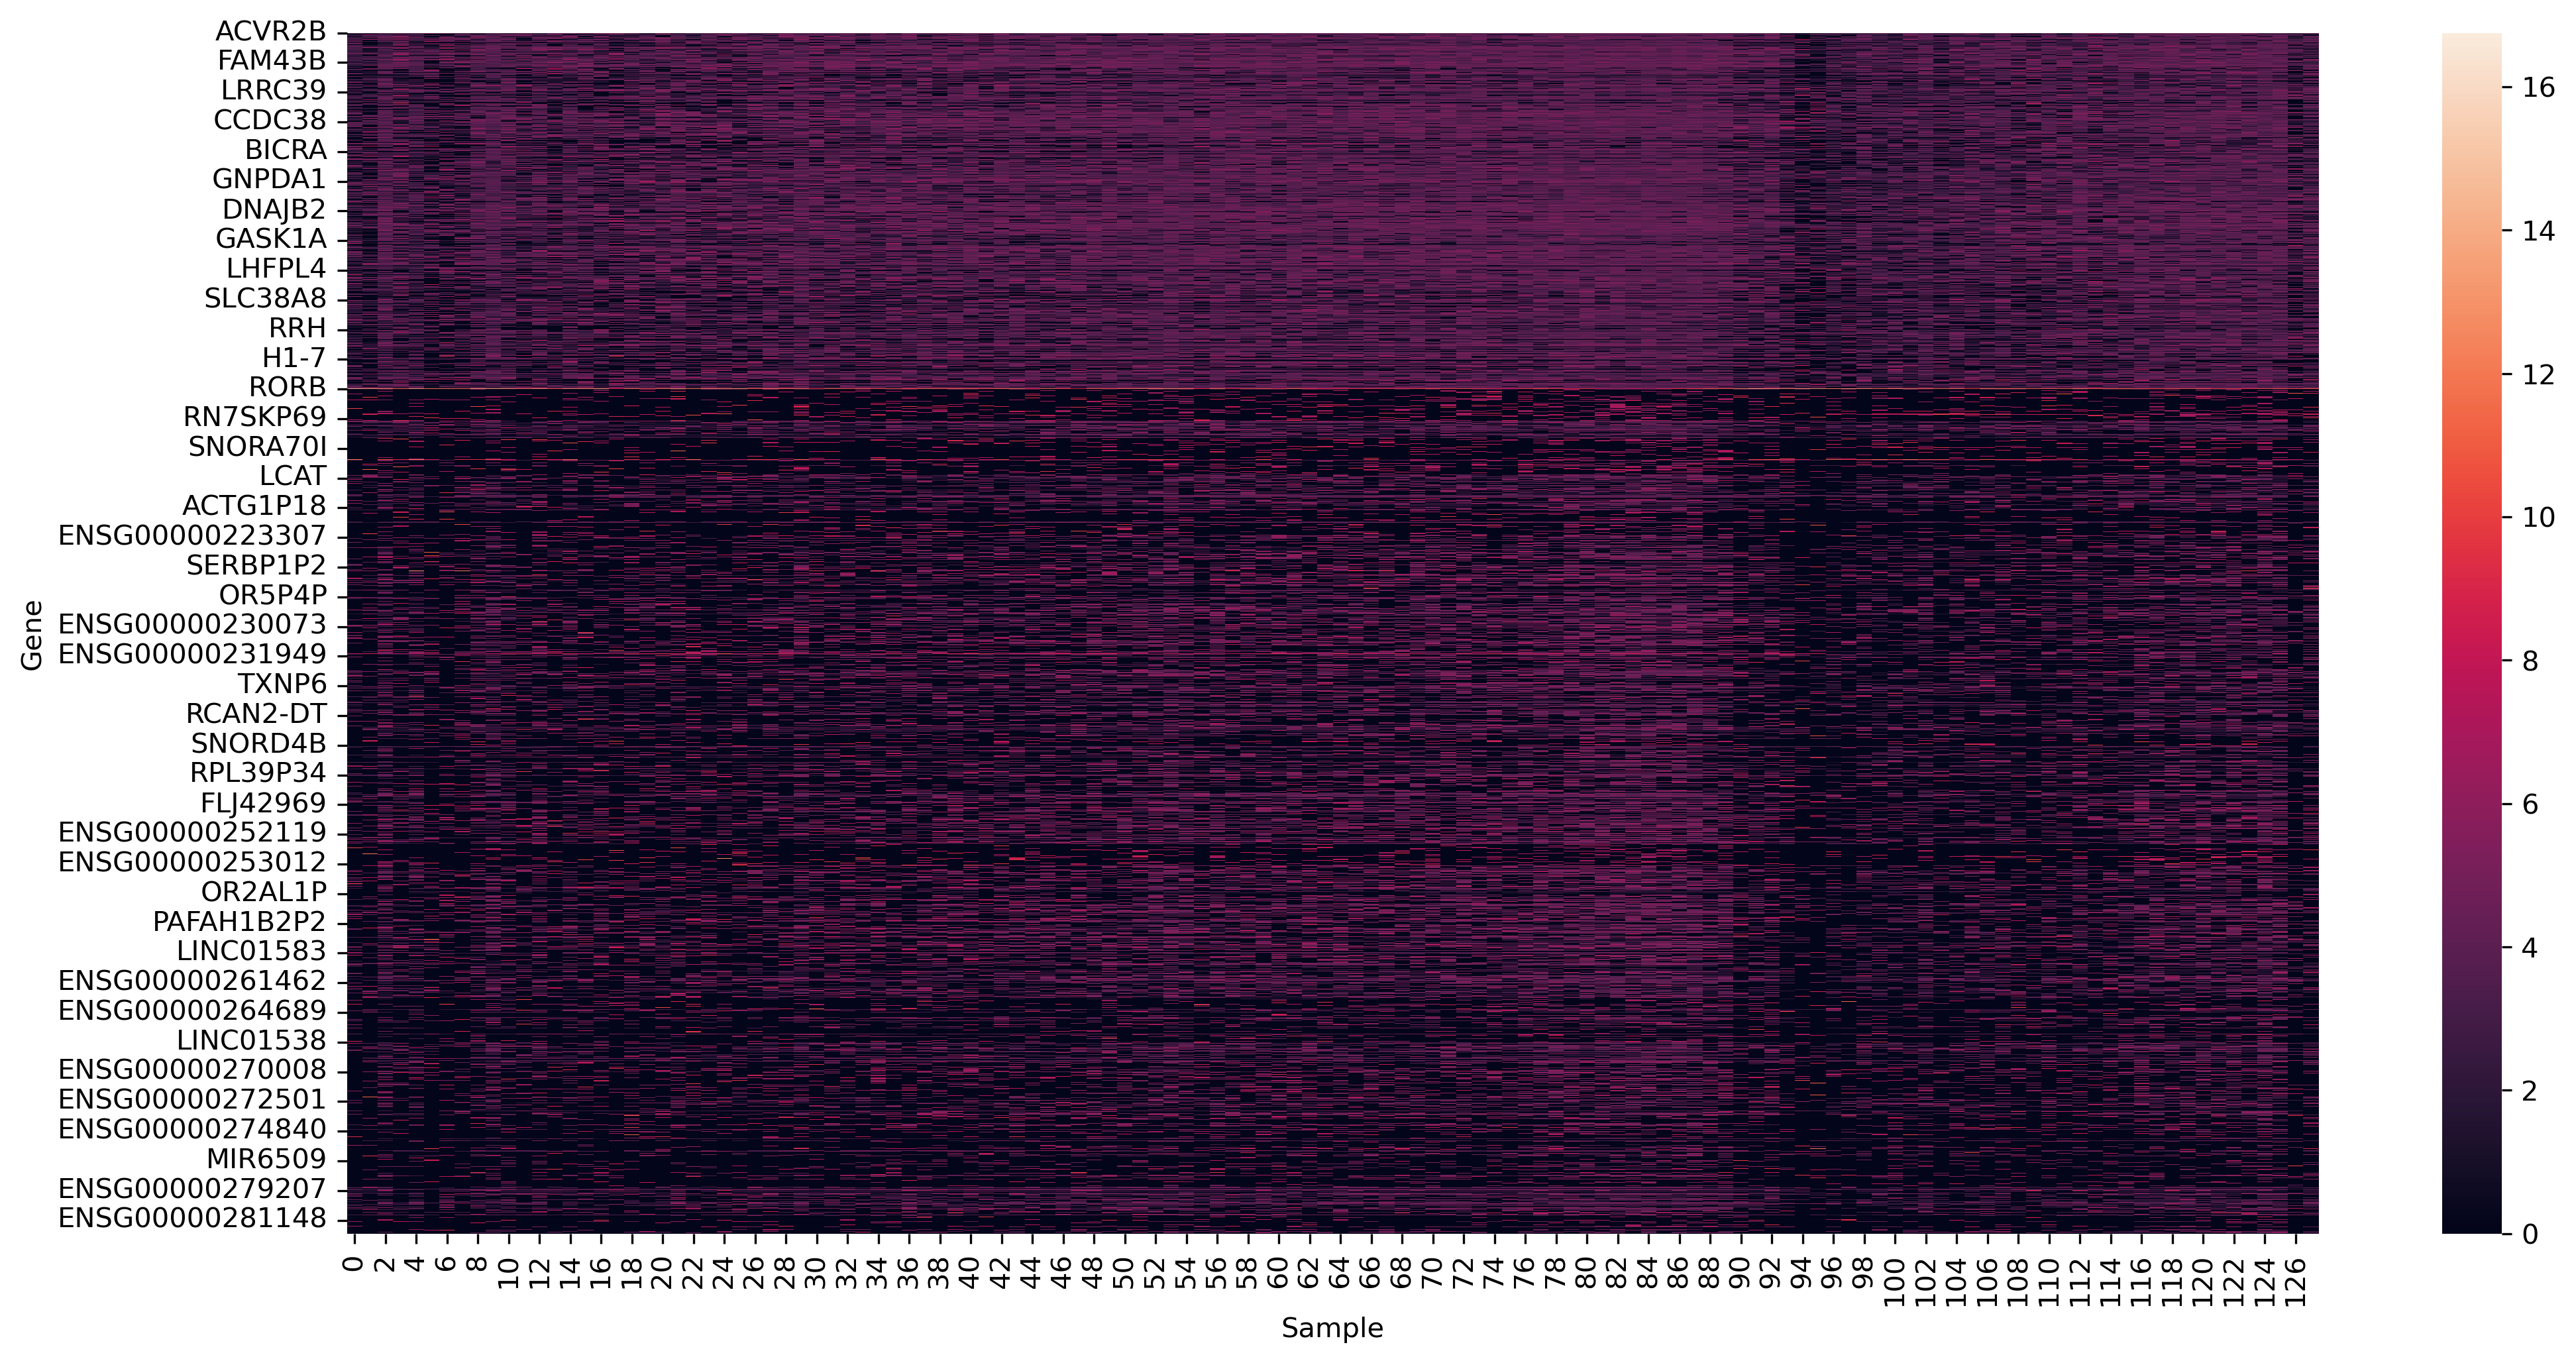

In [31]:
# Combine normal and cancer side by side
combined_matrix_for_heatmap = np.concatenate((reordered_cancer_data_matrix_2, reordered_normal_data_matrix_2), axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(np.log2(combined_matrix_for_heatmap+1), ax=ax)
ax.set_xlabel("Sample")

yticks = np.arange(0, len(sorted_genes), 1500)
ax.set_yticks(yticks)
ax.set_yticklabels([(ensemble_id_gene_name_dict[sorted_genes[i]] 
                     if sorted_genes[i] in ensemble_id_gene_name_dict else sorted_genes[i]) 
                    for i in yticks])
ax.set_ylabel("Gene")

In [32]:
len(reordered_cancer_data_matrix_2[0])

96

In [38]:
# Now repeat for validation

# Try instead with log normalized

gene_pval_dict = {}

genes = list(validation_data.index)

for gene in tqdm(genes):
    cancer_exprs = np.log2(np.array(val_cancer_data.loc[gene])+1)
    normal_exprs = np.log2(np.array(val_normal_data.loc[gene])+1)
    t, p = stats.ttest_ind(cancer_exprs, normal_exprs)
    gene_pval_dict[gene] = p

sorted_gene_pval_tups = sorted(gene_pval_dict.items(), key=lambda x: x[1])[:10]

sorted_genes = [] # genes sorted by p-value for cancer status t-test

for gene, pval in sorted(gene_pval_dict.items(), key=lambda x: x[1]):
    sorted_genes.append(gene)

100%|███████████████████████████████████| 60675/60675 [00:14<00:00, 4127.80it/s]


<AxesSubplot:>

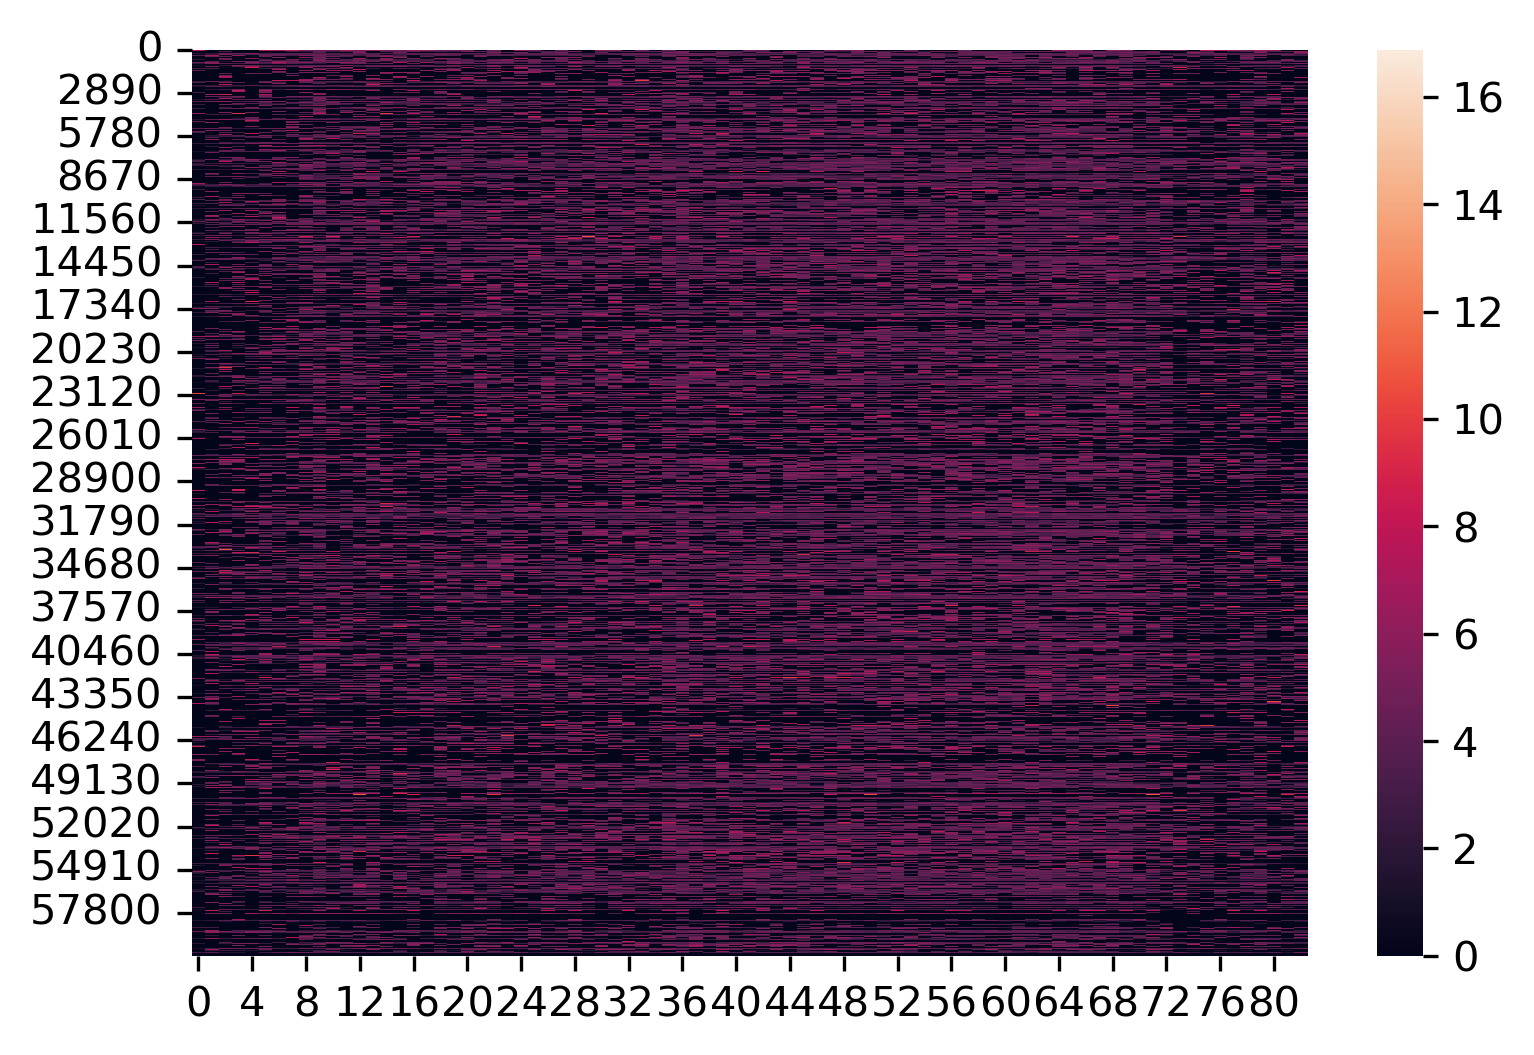

In [41]:
# Visualize cancer TPM values (log transformed)
# Order genes by difference between cancer and normal
cancer_data_matrix = np.array(val_cancer_data)

reordered_cancer_data_matrix = []
for gene in sorted_genes:
    reordered_cancer_data_matrix.append(np.array(val_cancer_data.loc[gene]))

reordered_cancer_data_matrix = np.array(reordered_cancer_data_matrix)

# Try clustering by sample
Z = scipy.cluster.hierarchy.linkage(reordered_cancer_data_matrix.T)
ordered_samples_idxs = scipy.cluster.hierarchy.leaves_list(Z)

reordered_cancer_data_matrix_2 = []
for sample_idx in ordered_samples_idxs:
    reordered_cancer_data_matrix_2.append(np.array(val_cancer_data.iloc[:,sample_idx]))

reordered_cancer_data_matrix_2 = np.array(reordered_cancer_data_matrix_2).T

sns.heatmap(np.log2(reordered_cancer_data_matrix_2+1))

<AxesSubplot:>

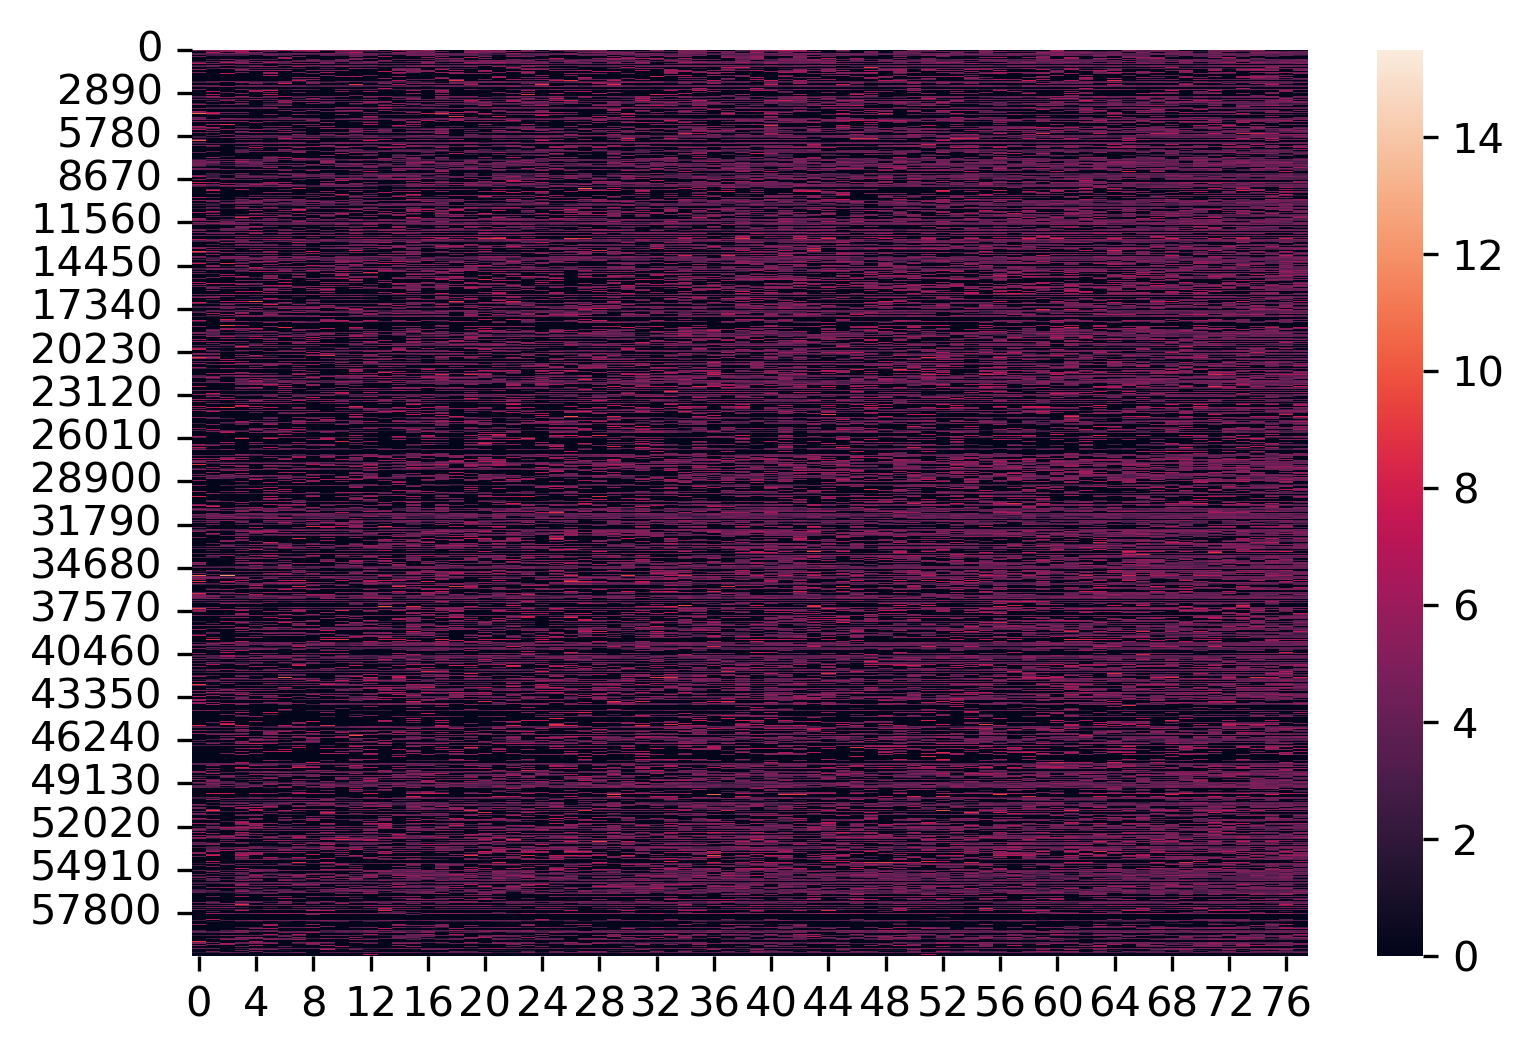

In [42]:
# Visualize normal TPM values (log transformed)
# Order genes by difference between normal and normal
normal_data_matrix = np.array(val_normal_data)

reordered_normal_data_matrix = []
for gene in sorted_genes:
    reordered_normal_data_matrix.append(np.array(val_normal_data.loc[gene]))

reordered_normal_data_matrix = np.array(reordered_normal_data_matrix)

# Try clustering by sample
Z = scipy.cluster.hierarchy.linkage(reordered_normal_data_matrix.T)
ordered_samples_idxs = scipy.cluster.hierarchy.leaves_list(Z)

reordered_normal_data_matrix_2 = []
for sample_idx in ordered_samples_idxs:
    reordered_normal_data_matrix_2.append(np.array(val_normal_data.iloc[:,sample_idx]))

reordered_normal_data_matrix_2 = np.array(reordered_normal_data_matrix_2).T

sns.heatmap(np.log2(reordered_normal_data_matrix_2+1))

Text(514.1666666666667, 0.5, 'Gene')

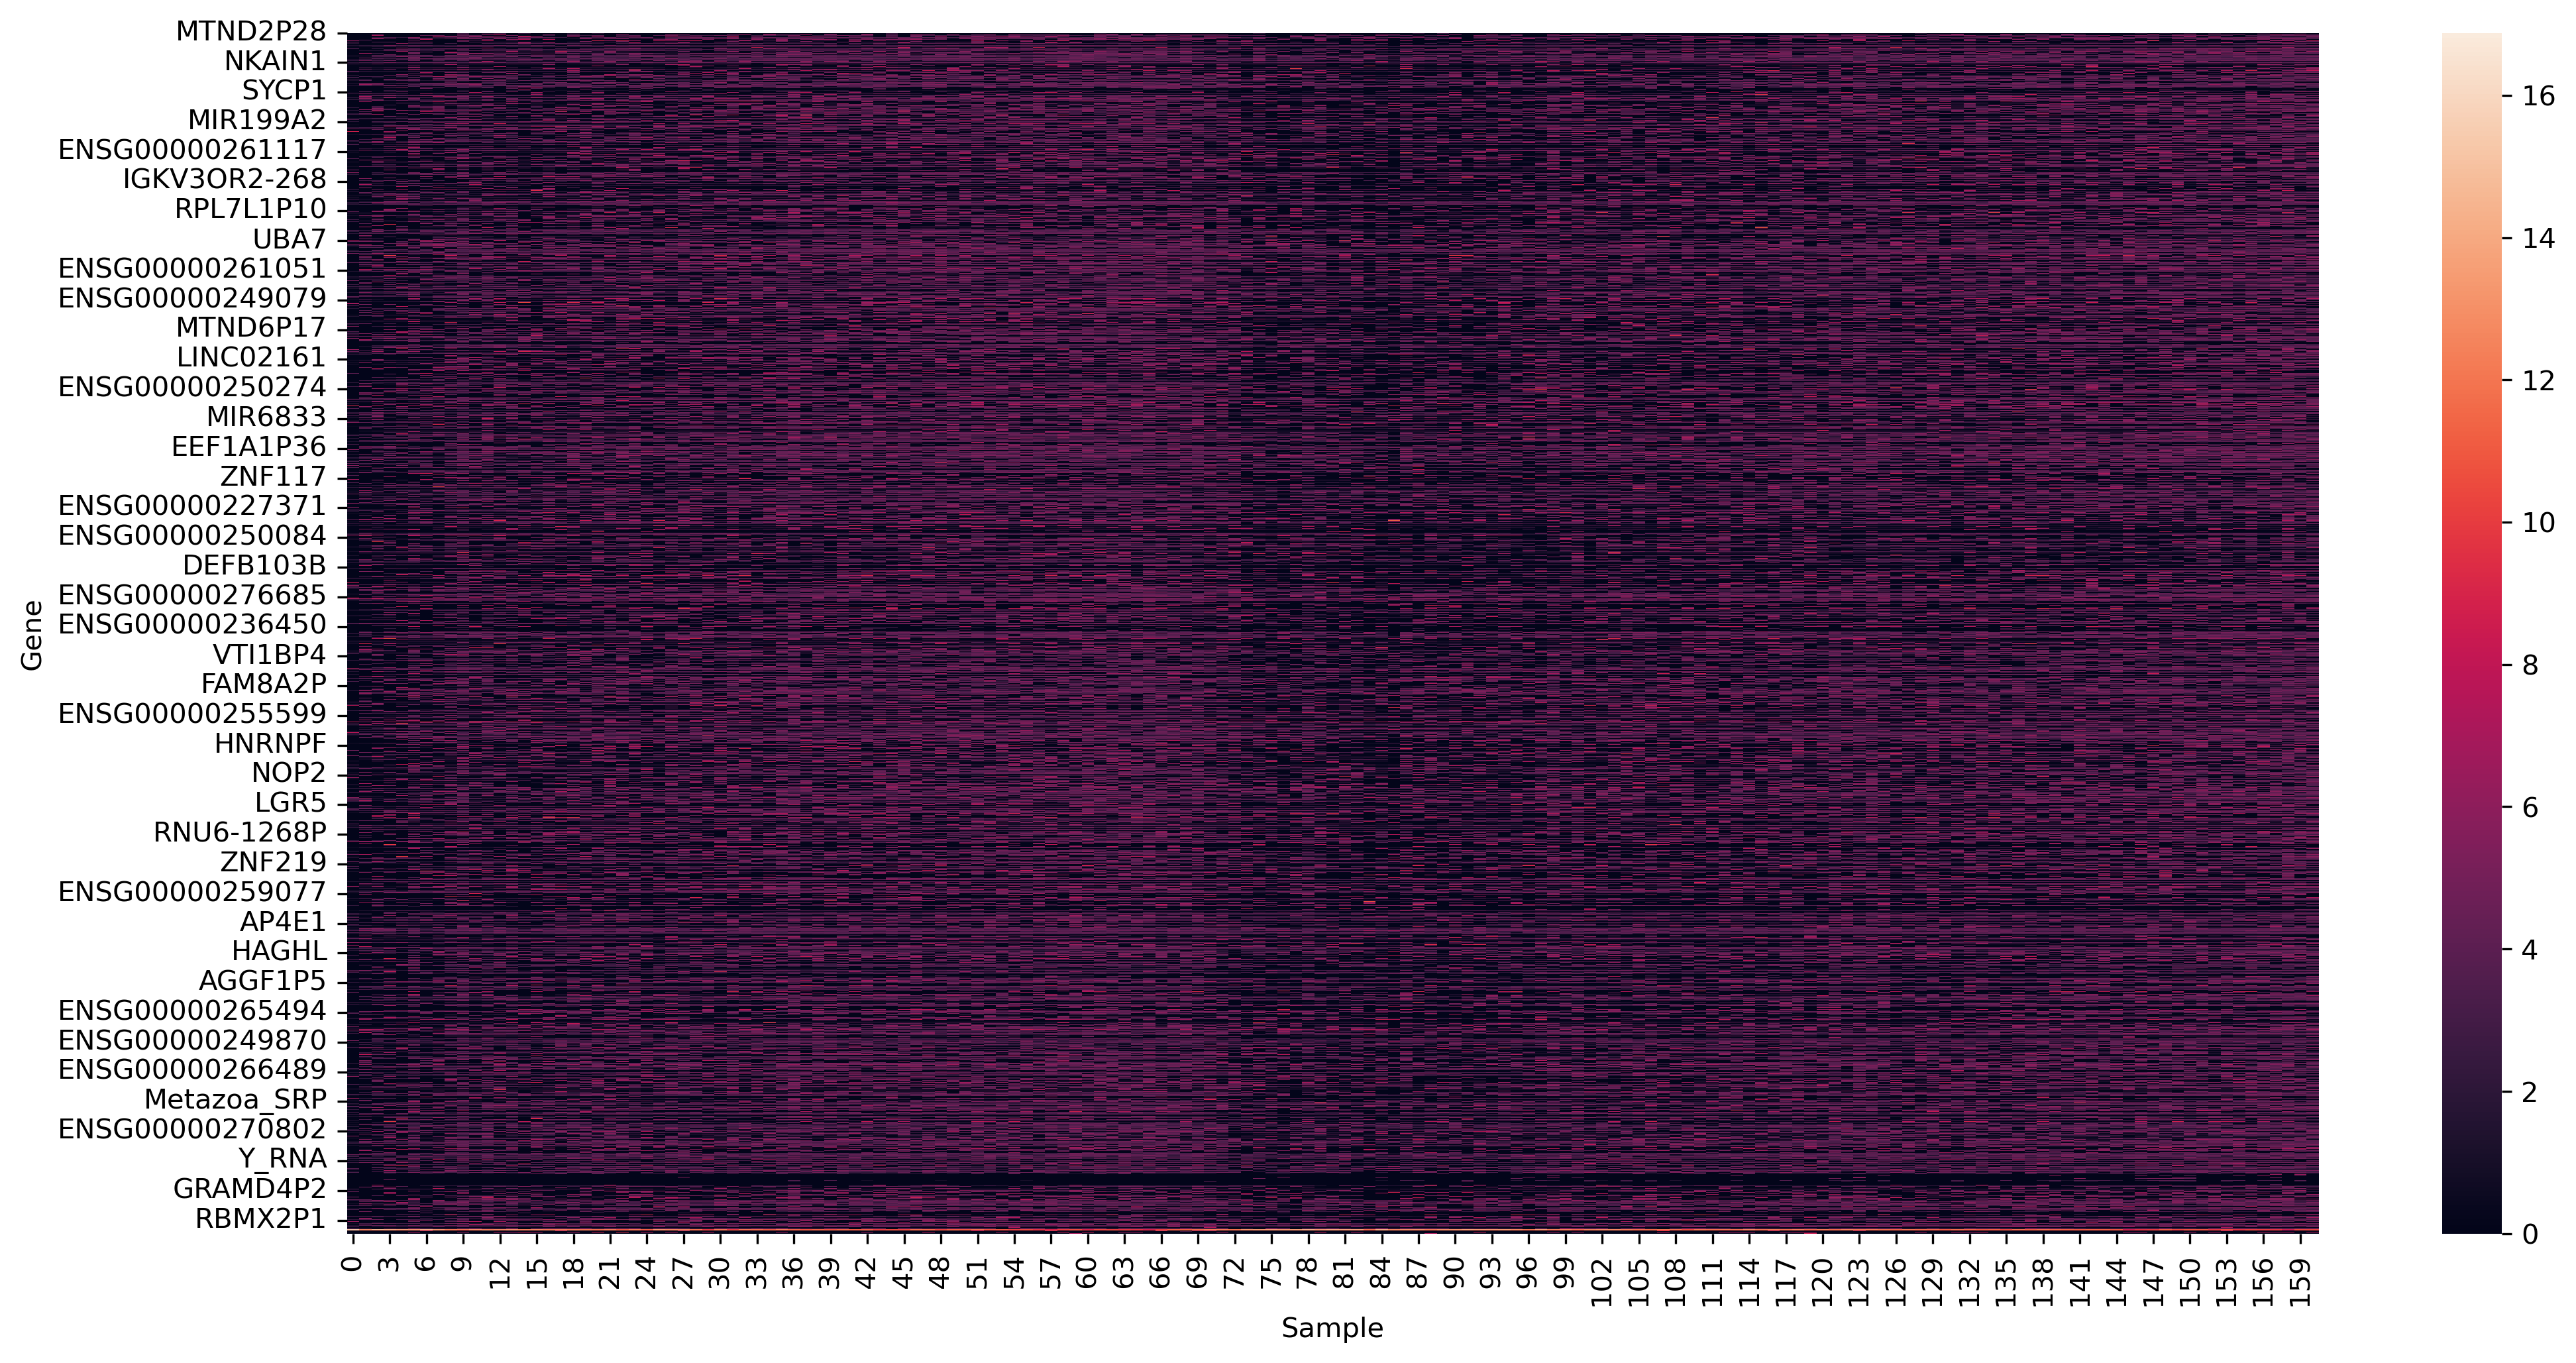

In [43]:
# Combine normal and cancer side by side
combined_matrix_for_heatmap = np.concatenate((reordered_cancer_data_matrix_2, reordered_normal_data_matrix_2), axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(np.log2(combined_matrix_for_heatmap+1), ax=ax)
ax.set_xlabel("Sample")

yticks = np.arange(0, len(sorted_genes), 1500)
ax.set_yticks(yticks)
ax.set_yticklabels([(ensemble_id_gene_name_dict[sorted_genes[i]] 
                     if sorted_genes[i] in ensemble_id_gene_name_dict else sorted_genes[i]) 
                    for i in yticks])
ax.set_ylabel("Gene")

In [44]:
len(reordered_cancer_data_matrix_2[0])

83